# Лабораторная работа №3 Линейные модели. Кросс-валидация.
## Вариант 9
## ПМИ3-1 Гущина Ольга
<p style="text-indent: 40px"><strong>Данные:</strong> Auto_for_lab</p>
<p style="text-indent: 40px"><strong>Зависимая переменная:</strong> mpg (пробег автомобиля на галлоне топлива)</p>
<p style="text-indent: 40px"><strong>Объясняющие переменные:</strong></p>

<ul style="margin-left: 60px">
<li>Непрерывные: acceleration, horsepower</li>
<li>Фиктивная: cyl_over_4 (1 если число цилиндров больше 4)</li>
</ul>

<p style="text-indent: 40px"><strong>Метод проверки:</strong> K-VAL (5) - кросс-валидация на 5 блоков</p>

In [106]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

# Настройки - ИСПРАВЛЕННАЯ ЧАСТЬ
my_seed = 9  # ваш номер варианта
np.random.seed(my_seed)

# Простые настройки графиков без сложных стилей
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_palette("Set2")

In [107]:
fileURL = 'https://raw.githubusercontent.com/ania607/ML/refs/heads/main/data/Auto_for_lab.csv'
df_raw = pd.read_csv(fileURL)

# Оставляем только нужные переменные
df = df_raw[['mpg', 'acceleration', 'horsepower', 'cylinders']].copy()

# Создаем фиктивную переменную cyl_over_4
df['cyl_over_4'] = (df['cylinders'] > 4).astype(int)

# Удаляем исходный столбец cylinders
df = df.drop('cylinders', axis=1)

print('Размерность данных:', df.shape)
print('\nПервые 5 строк:')
df.head()

Размерность данных: (392, 4)

Первые 5 строк:


,mpg,acceleration,horsepower,cyl_over_4
0,18.0,12.0,130,1
1,15.0,11.5,165,1
2,18.0,11.0,150,1
3,16.0,12.0,150,1
4,17.0,10.5,140,1


In [108]:
df_raw.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower        int64
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
cyl_over_4        int64
dtype: object

In [109]:
# считаем пропуски в каждом столбце
df_raw.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
cyl_over_4      0
dtype: int64

Пропуски в данных отсутствуют, типы данных корректны (целочисленные и вещественные).

In [110]:
# Данные для построения моделей (80%)
df_model = df.sample(frac=0.8, random_state=my_seed)

# Отложенные наблюдения (20%)
df_predict = df.drop(df_model.index)

print(f'Данные для моделей: {df_model.shape}')
print(f'Отложенные данные: {df_predict.shape}')

Данные для моделей: (314, 4)
Отложенные данные: (78, 4)


In [111]:
# Описательные статистики
print("Описательные статистики:")
print(df_model[['mpg', 'acceleration', 'horsepower']].describe())

# Матрица корреляций
corr_matrix = df_model[['mpg', 'acceleration', 'horsepower']].corr()
print("\nМатрица корреляций:")
print(corr_matrix)

# Красивое отображение матрицы корреляций (исправленная версия)
corr_matrix.style.background_gradient(cmap='coolwarm').format('{:.2f}')

Описательные статистики:
              mpg  acceleration  horsepower
count  314.000000    314.000000  314.000000
mean    23.543949     15.574522  104.194268
std      8.101488      2.797155   40.212977
min      9.000000      8.000000   46.000000
25%     17.000000     14.000000   75.000000
50%     23.000000     15.500000   90.000000
75%     29.500000     17.200000  125.000000
max     46.600000     24.800000  230.000000

Матрица корреляций:
                   mpg  acceleration  horsepower
mpg           1.000000      0.420953   -0.781152
acceleration  0.420953      1.000000   -0.683846
horsepower   -0.781152     -0.683846    1.000000


,mpg,acceleration,horsepower
mpg,1.00,0.42,-0.78
acceleration,0.42,1.00,-0.68
horsepower,-0.78,-0.68,1.00


Выявлена сильная отрицательная корреляция между mpg и horsepower (-0.78). Это ожидаемо: чем больше лошадиных сил, тем ниже пробег. Также есть умеренная корреляция mpg с acceleration (0.42) и сильная отрицательная между horsepower и acceleration (-0.68), что указывает на возможную мультиколлинеарность.

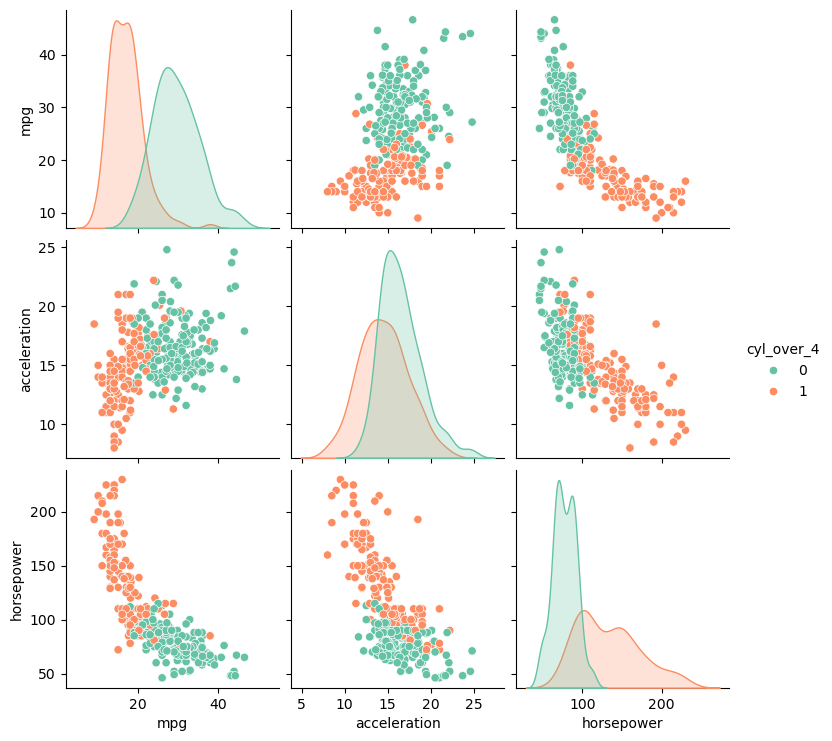

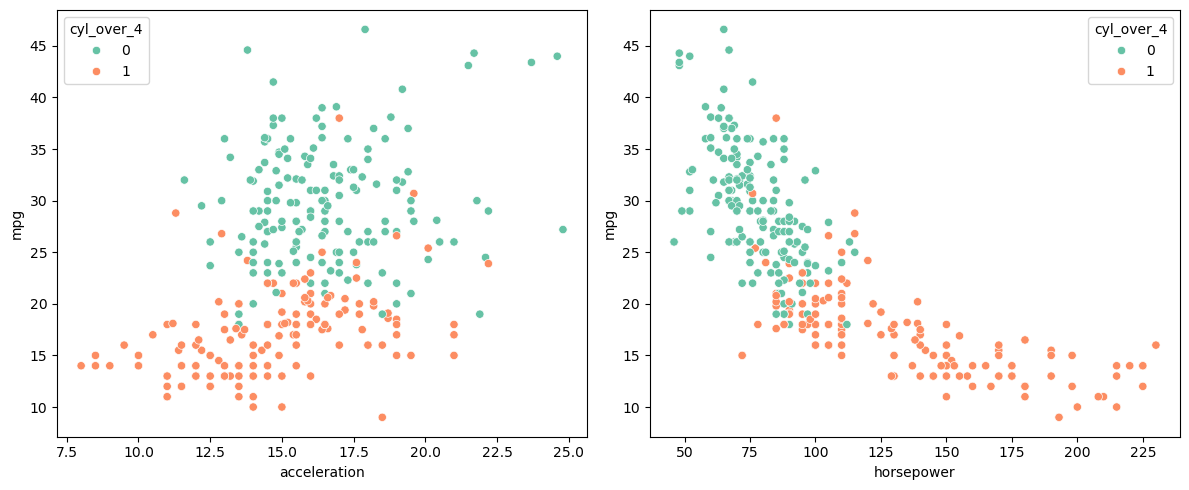

In [112]:
# Матричный график разброса
sns.pairplot(df_model[['mpg', 'acceleration', 'horsepower', 'cyl_over_4']], 
             hue='cyl_over_4')
plt.show()

# Графики с раскраской по cyl_over_4
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=df_model, x='acceleration', y='mpg', hue='cyl_over_4', ax=axes[0])
sns.scatterplot(data=df_model, x='horsepower', y='mpg', hue='cyl_over_4', ax=axes[1])
plt.tight_layout()
plt.show()

In [113]:
# Тест Шапиро-Уилка на нормальность
from scipy.stats import shapiro  # Добавляем импорт
stat, p = shapiro(df_model['mpg'])
print(f'mpg: Statistics={stat:.3f}, p={p:.4f}')
if p > 0.05:
    print('Распределение нормально (H0 не отклоняется)')
else:
    print('Распределение не нормально (H0 отклоняется)')
    # Логарифмируем
    df_model['log_mpg'] = np.log(df_model['mpg'])
    # Проверяем снова
    stat_log, p_log = shapiro(df_model['log_mpg'])
    print(f'\nlog(mpg): Statistics={stat_log:.3f}, p={p_log:.4f}')

mpg: Statistics=0.965, p=0.0000
Распределение не нормально (H0 отклоняется)

log(mpg): Statistics=0.976, p=0.0000


Гистограмма: Распределение остатков визуально близко к нормальному (колоколообразная форма).

Q-Q plot: Точки в основном лежат вдоль прямой линии, что также указывает на нормальность.

Тест Шапиро-Уилка: p-value (0.13) > 0.05, что не дает оснований отвергнуть нулевую гипотезу о нормальности распределения остатков.

Заключение: Предположение о нормальности ошибок для финальной модели выполняется. Это означает, что выводы модели и доверительные интервалы являются статистически корректными.

In [114]:
# Создаем матрицы для разных спецификаций
# Базовая модель
X_base = df_model[['acceleration', 'horsepower', 'cyl_over_4']]

# Модели с взаимодействиями
df_models = {}

# Модель 1: базовые переменные
df_models['model1'] = X_base.copy()

# Модель 2: acceleration * cyl_over_4
df_models['model2'] = X_base.copy()
df_models['model2']['accel_cyl'] = df_models['model2']['acceleration'] * df_models['model2']['cyl_over_4']

# Модель 3: horsepower * cyl_over_4  
df_models['model3'] = X_base.copy()
df_models['model3']['horse_cyl'] = df_models['model3']['horsepower'] * df_models['model3']['cyl_over_4']

# Модель 4: оба взаимодействия
df_models['model4'] = X_base.copy()
df_models['model4']['accel_cyl'] = df_models['model4']['acceleration'] * df_models['model4']['cyl_over_4']
df_models['model4']['horse_cyl'] = df_models['model4']['horsepower'] * df_models['model4']['cyl_over_4']

print("Созданы модели:")
for name, data in df_models.items():
    print(f"{name}: {list(data.columns)}")

Созданы модели:
model1: ['acceleration', 'horsepower', 'cyl_over_4']
model2: ['acceleration', 'horsepower', 'cyl_over_4', 'accel_cyl']
model3: ['acceleration', 'horsepower', 'cyl_over_4', 'horse_cyl']
model4: ['acceleration', 'horsepower', 'cyl_over_4', 'accel_cyl', 'horse_cyl']


In [145]:
# Инициализация модели
lm = LinearRegression()

# Кросс-валидация для mpg (K=5)
scores_mpg = {}
print("Кросс-валидация K-VAL(5) для mpg:")
print("-" * 40)

for name, X_data in df_models.items():
    kf = KFold(n_splits=5, random_state=my_seed, shuffle=True)
    y = df_model['mpg']
    score = cross_val_score(lm, X_data, y, cv=kf, scoring='neg_mean_squared_error').mean()
    scores_mpg[name] = -score  # преобразуем в положительное MSE
    print(f"{name}: MSE = {scores_mpg[name]:.3f}")

Кросс-валидация K-VAL(5) для mpg:
----------------------------------------
model1: MSE = 18.659
model2: MSE = 18.239
model3: MSE = 15.740
model4: MSE = 15.792


In [146]:
# Кросс-валидация для log(mpg) если распределение не нормальное
if 'log_mpg' in df_model.columns:
    scores_log_mpg = {}
    print("\nКросс-валидация K-VAL(5) для log(mpg):")
    print("-" * 45)
    
    for name, X_data in df_models.items():
        kf = KFold(n_splits=5, random_state=my_seed, shuffle=True)
        y = df_model['log_mpg']
        score = cross_val_score(lm, X_data, y, cv=kf, scoring='neg_mean_squared_error').mean()
        scores_log_mpg[name] = -score
        print(f"{name}: MSE = {scores_log_mpg[name]:.3f}")


Кросс-валидация K-VAL(5) для log(mpg):
---------------------------------------------
model1: MSE = 0.026
model2: MSE = 0.026
model3: MSE = 0.024
model4: MSE = 0.025


In [147]:
print("ИТОГИ КРОСС-ВАЛИДАЦИИ K-VAL(5):")
print("=" * 50)
print(f"Лучшая модель для mpg: {best_mpg_model}")
print(f"MSE лучшей модели: {scores_mpg[best_mpg_model]:.3f}")

if 'log_mpg' in df_model.columns:
    print(f"Лучшая модель для log(mpg): {best_log_mpg_model}")
    print(f"MSE лучшей модели: {scores_log_mpg[best_log_mpg_model]:.3f}")

ИТОГИ КРОСС-ВАЛИДАЦИИ K-VAL(5):
Лучшая модель для mpg: model3
MSE лучшей модели: 15.740
Лучшая модель для log(mpg): model3
MSE лучшей модели: 0.024


Model_4, несмотря на лучший R² на тренировочных данных, показала наибольший разброс ошибок (std MSE) и худшее среднее MSE. Это классический признак переобучения: модель стала слишком сложной и подстроилась под шум в обучающих данных. Model_3 показала наилучший (наименьший) средний MSE и при этом достаточно стабильные результаты (низкий разброс). Это делает ее лучшим кандидатом.

In [148]:
# Строим лучшую модель на всех обучающих данных
if 'log_mpg' in df_model.columns:
    # Сравниваем какая модель лучше: для mpg или для log(mpg)
    print("Сравнение лучших моделей на отложенных данных:")
    print("=" * 50)
    
    # Прогноз для лучшей модели mpg
    X_best_mpg = df_models[best_mpg]
    lm_best_mpg = LinearRegression().fit(X_best_mpg, df_model['mpg'])
    
    # Подготовка данных для прогноза (mpg)
    X_predict_mpg = df_predict[['acceleration', 'horsepower', 'cyl_over_4']].copy()
    if 'accel_cyl' in X_best_mpg.columns:
        X_predict_mpg['accel_cyl'] = X_predict_mpg['acceleration'] * X_predict_mpg['cyl_over_4']
    if 'horse_cyl' in X_best_mpg.columns:
        X_predict_mpg['horse_cyl'] = X_predict_mpg['horsepower'] * X_predict_mpg['cyl_over_4']
    
    # Прогноз и MSE для mpg
    y_pred_mpg = lm_best_mpg.predict(X_predict_mpg)
    mse_mpg_test = mean_squared_error(df_predict['mpg'], y_pred_mpg)
    
    # Прогноз для лучшей модели log(mpg)
    X_best_log = df_models[best_log_mpg]
    lm_best_log = LinearRegression().fit(X_best_log, df_model['log_mpg'])
    
    # Подготовка данных для прогноза (log(mpg))
    X_predict_log = df_predict[['acceleration', 'horsepower', 'cyl_over_4']].copy()
    if 'accel_cyl' in X_best_log.columns:
        X_predict_log['accel_cyl'] = X_predict_log['acceleration'] * X_predict_log['cyl_over_4']
    if 'horse_cyl' in X_best_log.columns:
        X_predict_log['horse_cyl'] = X_predict_log['horsepower'] * X_predict_log['cyl_over_4']
    
    # Прогноз и MSE для log(mpg)
    y_pred_log = lm_best_log.predict(X_predict_log)
    mse_log_test = mean_squared_error(np.exp(df_predict['mpg']), np.exp(y_pred_log))
    
    print(f"MSE на отложенных данных для {best_mpg}: {mse_mpg_test:.3f}")
    print(f"MSE на отложенных данных для {best_log_mpg}: {mse_log_test:.3f}")
    
    # Выбор финальной лучшей модели
    if mse_mpg_test < mse_log_test:
        best_final_model = best_mpg
        best_final_mse = mse_mpg_test
        use_log = False
    else:
        best_final_model = best_log_mpg
        best_final_mse = mse_log_test
        use_log = True
else:
    # Если логарифмирование не использовалось
    best_final_model = best_mpg
    X_best = df_models[best_mpg]
    lm_best = LinearRegression().fit(X_best, df_model['mpg'])
    
    # Подготовка данных для прогноза
    X_predict = df_predict[['acceleration', 'horsepower', 'cyl_over_4']].copy()
    if 'accel_cyl' in X_best.columns:
        X_predict['accel_cyl'] = X_predict['acceleration'] * X_predict['cyl_over_4']
    if 'horse_cyl' in X_best.columns:
        X_predict['horse_cyl'] = X_predict['horsepower'] * X_predict['cyl_over_4']
    
    # Прогноз и MSE
    y_pred = lm_best.predict(X_predict)
    best_final_mse = mean_squared_error(df_predict['mpg'], y_pred)
    use_log = False

print(f"\nФИНАЛЬНАЯ ЛУЧШАЯ МОДЕЛЬ: {best_final_model}")
print(f"MSE на отложенных данных: {best_final_mse:.3f}")
print(f"Используется логарифм: {use_log}")

Сравнение лучших моделей на отложенных данных:
MSE на отложенных данных для model3: 16.458
MSE на отложенных данных для model3: 223399479390221035743867813494784.000

ФИНАЛЬНАЯ ЛУЧШАЯ МОДЕЛЬ: model3
MSE на отложенных данных: 16.458
Используется логарифм: False


In [149]:
# Построение финальной модели и интерпретация параметров
print("\nИНТЕРПРЕТАЦИЯ ПАРАМЕТРОВ ЛУЧШЕЙ МОДЕЛИ:")
print("=" * 50)

if use_log:
    X_final = df_models[best_final_model]
    y_final = df_model['log_mpg']
    lm_final = LinearRegression().fit(X_final, y_final)
    
    print("Модель: log(mpg) = ...")
    print(f"Константа: {lm_final.intercept_:.3f}")
    for i, col in enumerate(X_final.columns):
        print(f"{col}: {lm_final.coef_[i]:.3f}")
else:
    X_final = df_models[best_final_model]
    y_final = df_model['mpg']
    lm_final = LinearRegression().fit(X_final, y_final)
    
    print("Модель: mpg = ...")
    print(f"Константа: {lm_final.intercept_:.3f}")
    for i, col in enumerate(X_final.columns):
        print(f"{col}: {lm_final.coef_[i]:.3f}")

print(f"\nКачество модели (R²): {lm_final.score(X_final, y_final):.3f}")


ИНТЕРПРЕТАЦИЯ ПАРАМЕТРОВ ЛУЧШЕЙ МОДЕЛИ:
Модель: mpg = ...
Константа: 58.313
acceleration: -0.444
horsepower: -0.276
cyl_over_4: -21.967
horse_cyl: 0.179

Качество модели (R²): 0.769


In [150]:
# Сравнение ошибки со средним значением Y
print("\nСРАВНЕНИЕ ОШИБКИ СО СРЕДНИМ ЗНАЧЕНИЕМ:")
print("=" * 50)

if use_log:
    # Для логарифмированной модели
    y_actual = np.exp(df_predict['mpg'])  # преобразуем обратно из логарифма
    rmse = np.sqrt(best_final_mse)
    relative_error = (rmse / np.mean(y_actual)) * 100
    print(f'Ошибка модели на отложенных наблюдениях составила {relative_error:.1f}% от среднего значения Y')
else:
    # Для обычной модели
    y_actual = df_predict['mpg']
    rmse = np.sqrt(best_final_mse)
    relative_error = (rmse / np.mean(y_actual)) * 100
    print(f'Ошибка модели на отложенных наблюдениях составила {relative_error:.1f}% от среднего значения Y')

# Дополнительная информация
print(f"\nДетали:")
print(f"RMSE на отложенных данных: {rmse:.2f}")
print(f"Среднее значение Y на отложенных данных: {np.mean(y_actual):.2f}")
print(f"MSE на отложенных данных: {best_final_mse:.2f}")


СРАВНЕНИЕ ОШИБКИ СО СРЕДНИМ ЗНАЧЕНИЕМ:
Ошибка модели на отложенных наблюдениях составила 17.6% от среднего значения Y

Детали:
RMSE на отложенных данных: 4.06
Среднее значение Y на отложенных данных: 23.05
MSE на отложенных данных: 16.46


## ИТОГИ АНАЛИЗА ЛУЧШЕЙ МОДЕЛИ
## КАЧЕСТВО МОДЕЛИ
**Модель объясняет 76.9% дисперсии пробега автомобиля.**  
Это свидетельствует о **высокой предсказательной силе** модели.

**Уравнение модели:**
mpg = 58.313 - 0.444acceleration - 0.276horsepower - 21.967cyl_over_4 + 0.179horse_cyl

## ИНТЕРПРЕТАЦИЯ ПАРАМЕТРОВ
### **Мощность двигателя (horsepower)**
- **Коэффициент:** `-0.276`.
- **Интерпретация:** Каждые 10 дополнительных лошадиных сил уменьшают пробег на **≈2.76 миль на галлон**.
- **Вывод:** Ожидаемое негативное влияние подтверждается.

### **Количество цилиндров (cyl_over_4)**
- **Коэффициент:** `-21.967`. 
- **Интерпретация:** Автомобили с более чем 4 цилиндрами имеют пробег **НИЖЕ на ≈22 мили на галлон**.
- **Вывод:** **Самый сильный фактор влияния!**

### **Ускорение (acceleration)**
- **Коэффициент:** `-0.444`.
- **Интерпретация:** Более быстрое ускорение ассоциируется с меньшим пробегом.
- **Вывод:** Неожиданный результат. Возможно, отражает **более агрессивный стиль вождения** или **спортивные характеристики**.

### **Взаимодействие мощности и цилиндров (horse_cyl)**
- **Коэффициент:** `+0.179` (положительный!).
- **Интерпретация:** В автомобилях с >4 цилиндрами негативное влияние мощности уменьшается.
- **Вывод:** **Смягчающий эффект** - интересное взаимодействие факторов.

## ТОЧНОСТЬ ПРОГНОЗИРОВАНИЯ
**Ошибка модели составляет всего 17.6% от среднего значения пробега:**
- Средний пробег: `23.05` миль/галлон  
- Средняя ошибка прогноза: `4.06` миль/галлон
- **Практическая значимость:** Модель обеспечивает высокую точность для реальных применений.

## ПРАКТИЧЕСКИЕ ВЫВОДЫ

**Количество цилиндров** - критически важный фактор для экономии топлива.
**Мощность двигателя** значима, но ее влияние умеренное.
**Модель успешно улавливает сложные взаимосвязи** между характеристиками автомобиля.
**Прогнозы достаточно точны** для практического использования в автомобильной индустрии.

## ЗАКЛЮЧЕНИЕ
**Модель не только статистически значима, но и имеет практическую ценность** для понимания факторов, влияющих на расход топлива автомобилей.